In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
import requests
import zipfile, io

url = 'https://www.dropbox.com/s/g0l60pmw6xet2cu/train.zip?dl=1'

request = requests.get(url, stream=True)

In [4]:
zip_filename = os.path.basename(url)[:-5]
file_dir = './.temp/'
with open(file_dir + zip_filename, 'wb') as zfile:
    zfile.write(request.content)


In [5]:
with zipfile.ZipFile(file_dir + zip_filename, "r") as z:
    z.extractall(path= file_dir)

In [6]:
train = pd.read_csv(file_dir + 'train.csv', sep=',', iterator=True, chunksize=200000, low_memory = False)
train = pd.concat(train, ignore_index=True)

In [7]:
top1 = train[train.item_nbr == 265559 ]
top1['date'] = pd.to_datetime(top1['date'])
top1['year'] = top1['date'].dt.year


<ipython-input-7-8252a5d71e97>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top1['date'] = pd.to_datetime(top1['date'])
<ipython-input-7-8252a5d71e97>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top1['year'] = top1['date'].dt.year


In [8]:
top1

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year
92,92,2013-01-01,25,265559,2.0,NaN,2013
754,754,2013-01-02,1,265559,36.0,NaN,2013
1780,1780,2013-01-02,2,265559,81.0,NaN,2013
2896,2896,2013-01-02,3,265559,86.0,NaN,2013
4087,4087,2013-01-02,4,265559,110.0,NaN,2013
...,...,...,...,...,...,...,...
125487093,125487093,2017-08-15,50,265559,40.0,False,2017
125489467,125489467,2017-08-15,51,265559,12.0,False,2017
125491686,125491686,2017-08-15,52,265559,20.0,False,2017
125494029,125494029,2017-08-15,53,265559,23.0,False,2017


#### Подготовим данные

In [9]:
unit_sales_by_date = top1.groupby('date').sum()['unit_sales']

In [14]:
#conda install -c conda-forge scikit-learn 


In [16]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

#### Импортируем метрики

In [18]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_percentage_error

### Тест Адфуллера для проверки стационарных временных рядов

In [19]:
from statsmodels.tsa.stattools import adfuller

X = unit_sales_by_date.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -6.447066
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Reject Ho - Time Series is Stationary


## Модель скользящего среднего

(1678,) (1684,)
mean_squared_error 1107332.3152562573
mean_absolute_error 692.564958283671
mean_absolute_percentage_error 60.3613016162271


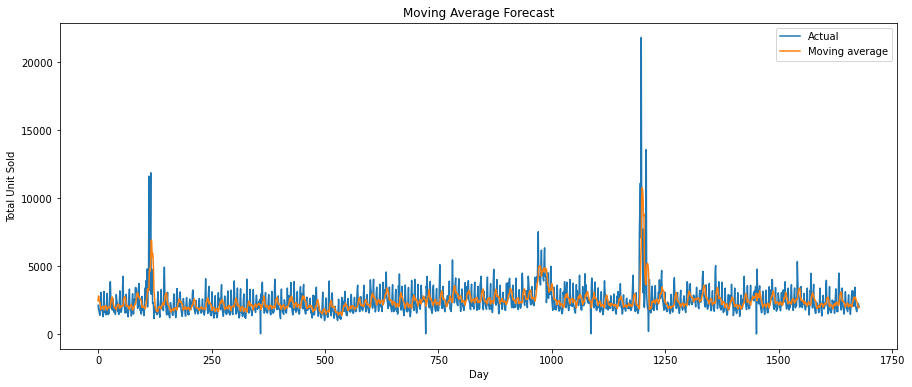

In [20]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)
moving_average_days = 6
moving_avg = moving_average_forecast(unit_sales_by_date,moving_average_days )# 

print(moving_avg.shape,unit_sales_by_date.shape)

print("mean_squared_error",mean_squared_error(unit_sales_by_date.values[moving_average_days:], moving_avg))
print("mean_absolute_error",mean_absolute_error(unit_sales_by_date.values[moving_average_days:], moving_avg))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(unit_sales_by_date.values[moving_average_days:], moving_avg))


plt.figure(figsize=(15,6))

plt.plot(unit_sales_by_date.values[moving_average_days:], label="Actual")
plt.plot(moving_avg, label="Moving average")
plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Moving Average Forecast")
plt.legend(loc="upper right")

[[ 0.2340022  -0.12782254  0.04790463  0.00736804  0.02826361  0.50030544]]
[757.83281281]
mean_squared_error 408986.0652349749
mean_absolute_error 462.6414577284896
mean_absolute_percentage_error 159.14522818211267


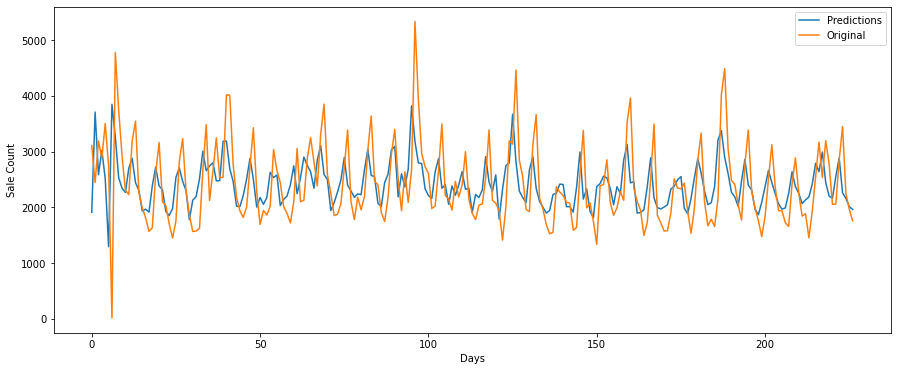

In [21]:
x_train = unit_sales_by_date['2013':'2016'].values
x_test  = unit_sales_by_date['2017'].values

df = pd.DataFrame()

df["Original Values"]  = unit_sales_by_date
df["shift1"] = df["Original Values"].shift()
df["shift2"] = df["shift1"].shift()
df["shift3"] = df["shift2"].shift()
df["shift4"] = df["shift3"].shift()
df["shift5"] = df["shift4"].shift()
df["shift6"] = df["shift5"].shift()


lag_value = 6
df.dropna(inplace=True)


x_train, y_train = df['2013':'2016'].iloc[:,0:lag_value].values, df['2013':'2016'].iloc[:,lag_value:].values
x_test, y_test = df['2017'].iloc[:,0:lag_value].values, df['2017'].iloc[:,lag_value:].values

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)
print(reg.coef_)
print(reg.intercept_)


ar_predictions = reg.predict(x_test)

plt.figure(figsize=(15,6))
plt.plot(ar_predictions ,label = "Predictions")
plt.plot(y_test, label = "Original" )
plt.xlabel("Days")
plt.ylabel("Sale Count")

print("mean_squared_error",mean_squared_error(y_test, ar_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, ar_predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, ar_predictions))


plt.legend(loc="upper right")

Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 3-х параметров:
    
    p — порядок компоненты AR
    d — порядок интегрированного ряда
    q — порядок компонетны MA
    
d мы уже знаем - это 1

осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.

ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов.

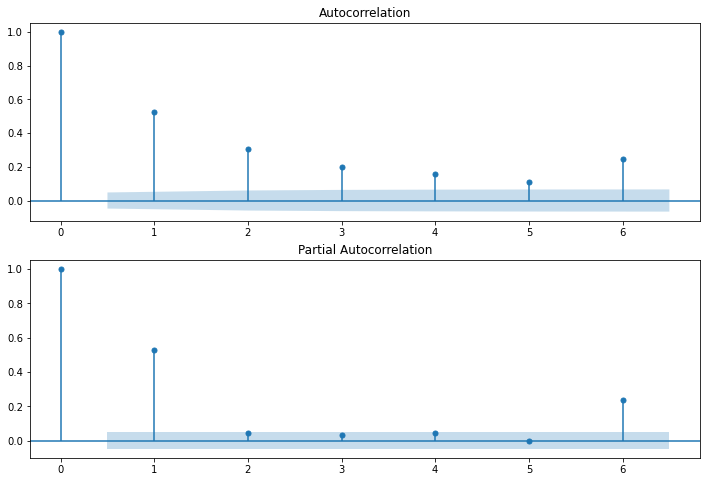

In [22]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(unit_sales_by_date.values.squeeze(), lags=6, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(unit_sales_by_date, lags=6, ax=ax2)

После изучения коррелограммы PACF можно сделать вывод, что p = 6, т.к. на ней все лаги сильно отличны от нуля.
По коррелограмме ACF можно предположить, что q = 6, т.к. на лаг 6 значении функций резко возрастает. Итак, когда известны все параметры можно построить модель.

## ARMA Model

C:\Users\asyac\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


mean_squared_error 571878.9390099199
mean_absolute_error 570.0591958491693
mean_absolute_percentage_error 160.30475245149088


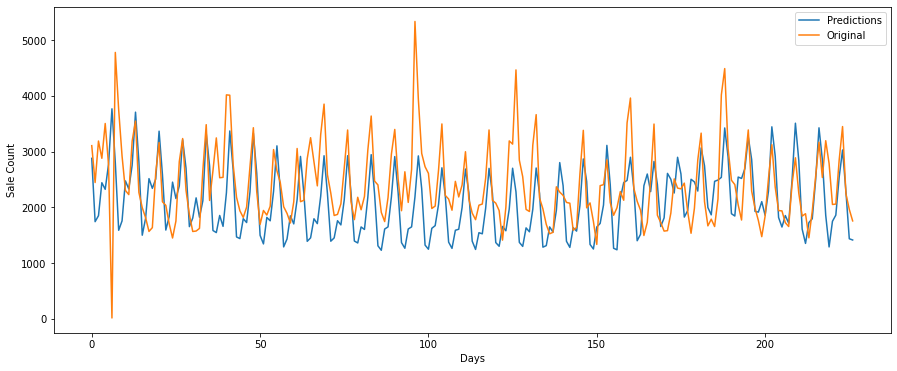

In [23]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from datetime import datetime, timedelta

x_train, y_train = df['2013':'2016'].iloc[:,0:lag_value], df['2013':'2016'].iloc[:,lag_value:]
x_test, y_test = df['2017'].iloc[:,0:lag_value], df['2017'].iloc[:,lag_value:]

ARMA_model = ARMA(x_train.values.reshape(-1).tolist(), (6,6)).fit()
arma_predictions = ARMA_model.predict(start=len(x_train), end=len(x_train) + len(x_test)-1, dynamic=False)


plt.figure(figsize=(15,6))
plt.plot(arma_predictions ,label = "Predictions")
plt.plot(y_test.values, label = "Original" )
plt.xlabel("Days")
plt.ylabel("Sale Count")
plt.legend(loc="upper right")

print("mean_squared_error",mean_squared_error(y_test, arma_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, arma_predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, arma_predictions))



## ARIMA model

In [24]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(x_train['Original Values'].values, (6,1,6)).fit()



C:\Users\asyac\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asyac\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn

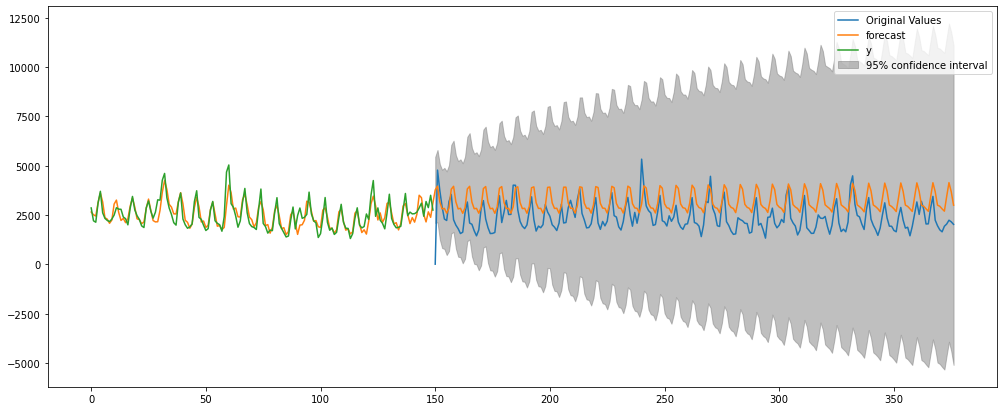

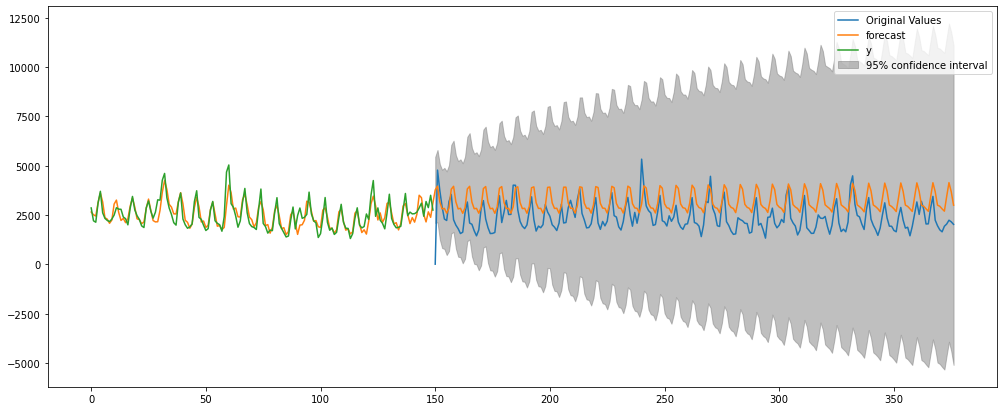

In [25]:
fig, ax = plt.subplots(figsize=(17,7))
shown_train_size = 150
train_size = len(x_train['Original Values'].values)
test_size = len(x_test['Original Values'].values) 
ax = x_test.set_index(pd.Series(range(shown_train_size, shown_train_size + test_size)))['Original Values'].plot(ax=ax)
model.plot_predict(start=train_size-shown_train_size,end=train_size+test_size -1,dynamic=False, plot_insample=True,ax=ax)

In [26]:
arima_predictions = model.predict(train_size, train_size + test_size -1)
print("mean_squared_error",mean_squared_error(y_test, arima_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, arima_predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, arima_predictions))



mean_squared_error 6339340.393511839
mean_absolute_error 2410.204298769358
mean_absolute_percentage_error 110.5200134794688
